In [ ]:
# notebooks/final_comparison.ipynb

In [7]:
#Import Libraries and Helpers
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from helpers.visualization_helpers import plot_confusion_matrix
from tensorflow.keras.models import load_model
import joblib
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np


In [13]:
custom_palette = [
    '#1E4436',  
    '#35AF8A',  
    '#32D99C',  # Original middle shade
    '#23FEAE',  
    '#C1FFE8',  
]

In [9]:
y_test = joblib.load('../outputs/models/y_test.joblib')

X_test_bow = joblib.load('../outputs/models/X_test_BOW.joblib')
X_test_tfidf = joblib.load('../outputs/models/X_test_TFIDF.joblib')
X_test_spacy= joblib.load('../outputs/models/X_test_Spacy.joblib')

In [10]:
# define paths to models for each embedding technique
model_paths = {
    'TFIDF': {
        'Random Forest': '../outputs/models/Random_Forest_TFIDF.joblib',
        'Neural Network': '../outputs/models/Neural_Network_TFIDF.keras'
    },
    'BOW': {
        'Random Forest': '../outputs/models/Random_Forest_BOW.joblib',
        'Neural Network': '../outputs/models/Neural_Network_BOW.keras'
    },
    'SpaCy': {
        'Random Forest': '../outputs/models/Random_Forest_SPACY.joblib',
        'Neural Network': '../outputs/models/Neural_Network_SPACY.keras'
    }
}

results = {} # store in dict

# Iterate through each embedding technique and evaluate the models
for vectorization, models in model_paths.items():
    for model_name, model_path in models.items():
        print(f"Evaluating {model_name} with {vectorization} embeddings...")

        # Load the model
        if 'Neural Network' in model_name:
            model = load_model(model_path)

            # Use correct test data depending on the vectorization method
            if vectorization == 'TFIDF':
                X_test_dense = X_test_tfidf.toarray()
            elif vectorization == 'BOW':
                X_test_dense = X_test_bow.toarray()
            else:
                X_test_dense = X_test_spacy

            # Neural Network predictions
            y_pred_probs = model.predict(X_test_dense)
            y_pred = np.argmax(y_pred_probs, axis=1) + 1  # Adjust labels back to 1-5
        else:
            model = joblib.load(model_path)

            # Use correct test data for the Random Forest
            if vectorization == 'TFIDF':
                X_test = X_test_tfidf
            elif vectorization == 'BOW':
                X_test = X_test_bow
            else:
                X_test = X_test_spacy

            y_pred = model.predict(X_test)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
        results[(vectorization, model_name)] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        }

Evaluating Random Forest with TFIDF embeddings...
Evaluating Neural Network with TFIDF embeddings...
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Evaluating Random Forest with BOW embeddings...
Evaluating Neural Network with BOW embeddings...
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Evaluating Random Forest with SpaCy embeddings...
Evaluating Neural Network with SpaCy embeddings...
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [11]:
# Create a DataFrame from results
results_df = pd.DataFrame(results).T
print("\nModel Performance Comparison:")
print(results_df)

# Save comparison table
results_df.to_csv('../outputs/models/model_comparison_metrics.csv')
print("\nModel comparison metrics saved successfully.")

# Prepare data for visualization
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
results_df.reset_index(inplace=True)
results_df = results_df.rename(columns={'level_0': 'Vectorization', 'level_1': 'Model'})

# Melt the DataFrame for seaborn visualization
results_melted = results_df.melt(id_vars=['Vectorization', 'Model'], value_vars=metrics, var_name='Metric', value_name='Score')



Model Performance Comparison:
                      Accuracy  Precision    Recall  F1-Score
TFIDF Random Forest   0.550866   0.522529  0.550866  0.528013
      Neural Network  0.558429   0.554931  0.558429  0.556240
BOW   Random Forest   0.532569   0.512356  0.532569  0.513959
      Neural Network  0.566968   0.560724  0.566968  0.561658
SpaCy Random Forest   0.512076   0.502689  0.512076  0.505643
      Neural Network  0.564040   0.576277  0.564040  0.568543

Model comparison metrics saved successfully.


C:\Users\paige\AppData\Local\Temp\ipykernel_32280\508464302.py:3: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.barplot(x='Metric', y='Score', hue='Model', data=results_melted, palette=custom_palette)


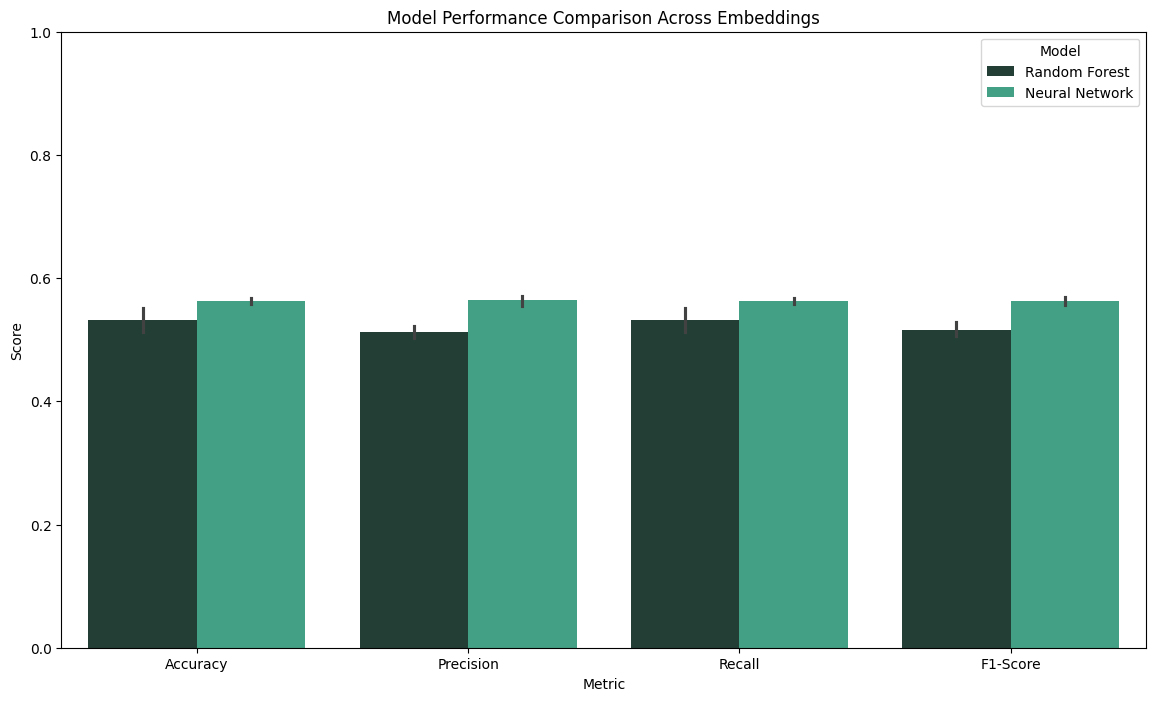

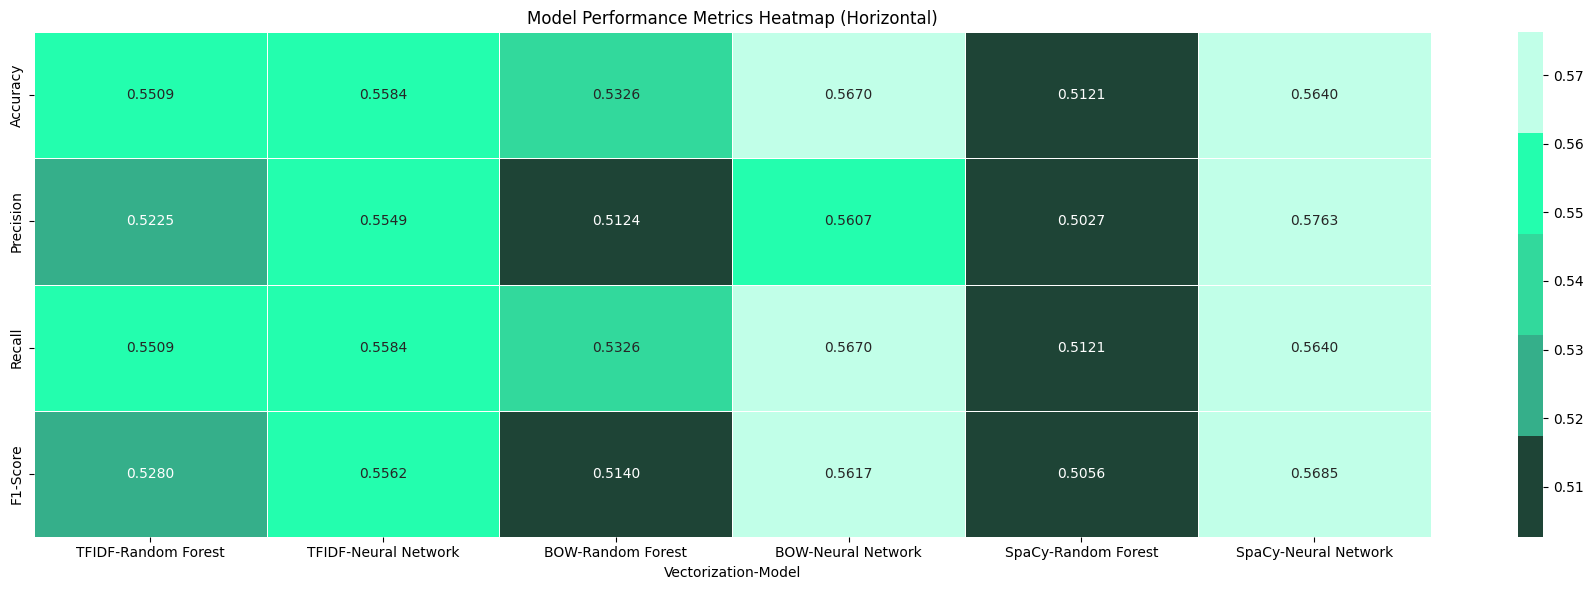

In [14]:
# Plot model performance comparison
plt.figure(figsize=(14, 8))
sns.barplot(x='Metric', y='Score', hue='Model', data=results_melted, palette=custom_palette)
plt.title("Model Performance Comparison Across Embeddings")
plt.ylim(0, 1)
plt.legend(title='Model')
plt.savefig('../outputs/figures/model_performance_comparison.png')
plt.show()

# Optional: Display the comparison table in a horizontally oriented heatmap
plt.figure(figsize=(18, 6))
sns.heatmap(results_df.set_index(['Vectorization', 'Model']).T, annot=True, cmap=custom_palette, fmt=".4f", linewidths=0.5)
plt.title("Model Performance Metrics Heatmap (Horizontal)")
plt.tight_layout()
plt.show()